In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
sick_dir = '/content/drive/MyDrive/6.819 Computer Vision/Final Project/chest_xray/test/PNEUMONIA'
healthy_dir = '/content/drive/MyDrive/6.819 Computer Vision/Final Project/chest_xray/train'
test_sick_dir = '/content/drive/MyDrive/6.819 Computer Vision/Final Project/chest_xray/test_sick'
test_healthy_dir = '/content/drive/MyDrive/6.819 Computer Vision/Final Project/chest_xray/test_healthy'

In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Random Seed:  999
Using the GPU!


In [4]:
def conv(in_c, out_c, kernel, stride=1, padding=1, dilation=1, batch_norm=True):
  '''
    Creates specified convolutional module for the discriminator
  '''

  if batch_norm:
    return nn.Sequential(*[nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=kernel, stride=stride, padding=padding, dilation=dilation),
                           nn.BatchNorm2d(out_c)])
  else:
    return nn.Sequential(*[nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=kernel, stride=stride, padding=padding, dilation=dilation)])

def convTrans(in_c, out_c, kernel, stride=1, padding=1, dilation=1, batch_norm=True):
  '''
    creates specified convTranspose for the generator
  '''
  if batch_norm:
    return nn.Sequential(*[nn.ConvTranspose2d(in_channels=in_c, out_channels=out_c, kernel_size=kernel, stride=stride, padding=padding, dilation=dilation),
                           nn.BatchNorm2d(out_c)])
  else:
    return nn.Sequential(*[nn.ConvTranspose2d(in_channels=in_c, out_channels=out_c, kernel_size=kernel,  stride=stride, padding=padding, dilation=dilation)])

In [5]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
      super(Discriminator, self).__init__()

      self.conv1 = conv(3,conv_dim,4,batch_norm = False)
      self.conv2 = conv(conv_dim,conv_dim*2,4)
      self.conv3 = conv(conv_dim*2,conv_dim*4,4)
      self.conv4 = conv(conv_dim*4,conv_dim*8,4, batch_norm = False)

    def forward(self, x):

      x = nn.functional.leaky_relu(self.conv1(x))
      x = nn.functional.leaky_relu(self.conv2(x))
      x = nn.functional.leaky_relu(self.conv3(x))
      return self.conv4(x)

class ResidualBlock(nn.Module):
  '''
    Connects discriminators and generator
  '''

  def __init__(self, conv_dim):
    super(ResidualBlock, self).__init__()

    self.layer_1 = conv(conv_dim, conv_dim, 3, 1, 1, 1, batch_norm=True)
    self.layer_2 = conv(conv_dim, conv_dim, 3, 1, 1, 1, batch_norm=True)

  def forward(self, x):

    return x + self.layer_2(nn.functional.relu(self.layer_1(x)))

class Generator(nn.Module):

  def __init__(self, conv_dim=64, n_res_blocks=6):
    super(Generator, self).__init__()

    #encoder
    self.enc1 = conv(3, conv_dim, 4)
    self.enc2 = conv(conv_dim, conv_dim*2, 4)
    self.enc3 = conv(conv_dim*2, conv_dim*4, 4)


    #resnet
    self.blocks = nn.Sequential(*[ResidualBlock(conv_dim*4) for _ in range(n_res_blocks)])

    # decoder

    self.dec1 = convTrans(conv_dim*4, conv_dim*2, 4)
    self.dec2 = convTrans(conv_dim*2, conv_dim, 4)
    self.dec3 = convTrans(conv_dim, 3, 4, batch_norm=False)

  def forward(self, x):

    out = nn.functional.relu(self.enc1(x))
    out = nn.functional.relu(self.enc2(out))
    out = nn.functional.relu(self.enc3(out))

    out = self.blocks(out)

    out = nn.functional.relu(self.dec1(out))
    out = nn.functional.relu(self.dec2(out))
    out = torch.tanh(self.dec3(out))

    return out


In [6]:
def real_loss(D_out):
  return torch.mean((D_out - 1)**2)

def fake_loss(D_out):
  return torch.mean(D_out **2)

def cycle_consistency_loss(real, reconstruct, l_weight):
  return l_weight * torch.mean(torch.abs(real - reconstruct))

In [13]:
def scale(x):
  return x/torch.max(x)

def training_loop(G_XtoY, G_YtoX, D_X, D_Y, dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, epochs=500):

    tracker, losses = 5, []

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(epochs):

      if epoch % batches_per_epoch == 0:
        iter_X = iter(dataloader_X)
        iter_Y = iter(dataloader_Y)

      X_im, _ = iter_X.next()
      X_im = scale(X_im).to(device)
      Y_im, _ = iter_Y.next()
      Y_im = scale(Y_im).to(device)

      discriminator_loss = 0

      for pair in ((d_x_optimizer, G_YtoX, D_X, X_im, Y_im), (d_y_optimizer, G_XtoY, D_Y, Y_im, X_im)):
        optimizer = pair[0]
        generator = pair[1]
        discriminator = pair[2]
        optimizer.zero_grad()
        loss = real_loss(discriminator(pair[3])) + fake_loss(discriminator(G_YtoX(pair[4])))
        loss.backward()
        optimizer.step()
        discriminator_loss += loss.item()

        g_optimizer.zero_grad()

        g_loss = real_loss(D_X(G_YtoX(Y_im)))
        y_cycle = G_XtoY(G_YtoX(Y_im))
        g_loss += cycle_consistency_loss(Y_im, y_cycle, 10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        # 5. Add up all generator and reconstructed losses and perform backprop
        g_loss += real_loss(D_Y(G_XtoY(X_im)))
        x_cycle = G_YtoX(G_XtoY(X_im))
        g_loss +=  cycle_consistency_loss(X_im, x_cycle, 10)

        g_loss.backward()
        g_optimizer.step()


      if epoch % tracker == 0:
        losses.append((discriminator_loss, g_loss))
        print(str(epoch) + " : " + str(discriminator_loss) + " , " + str(g_loss.item()))

    return losses


In [8]:
input_size = 128
batch_size = 1

def scale(x):
  return x/torch.max(x)

data_transforms = transforms.Compose([
      transforms.Resize(input_size),
      transforms.ToTensor(),
      transforms.RandomRotation(15),
      transforms.RandomHorizontalFlip(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
def get_dataloaders(input_size, batch_size, shuffle = True):

  sick_dataloader = torch.utils.data.DataLoader(dset.ImageFolder(sick_dir, data_transforms), shuffle=shuffle, num_workers=2)
  healthy_dataloader = torch.utils.data.DataLoader(dset.ImageFolder(healthy_dir, data_transforms), shuffle=shuffle, num_workers=2)

  return sick_dataloader, healthy_dataloader


test_sick_dl = torch.utils.data.DataLoader(dset.ImageFolder(test_sick_dir, data_transforms), shuffle=False, num_workers=2)
test_healthy_dl = torch.utils.data.DataLoader(dset.ImageFolder(test_healthy_dir, data_transforms), shuffle=False, num_workers=2)
sick_loader, healthy_loader = get_dataloaders(input_size, batch_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 128, 157)


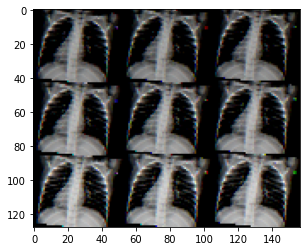

In [9]:
iter_sick = iter(healthy_loader)

sick_images, _ = iter_sick.next()

sick_images = scale(sick_images)
img_np = np.asarray(sick_images[0])
print(img_np.shape)
img_np = img_np.reshape((input_size, img_np.shape[2], 3))
plt.imshow(img_np)

In [10]:
conv_dim = input_size
gen_healthy_to_sick = Generator(conv_dim)
gen_sick_to_healthy = Generator(conv_dim)
dis_healthy = Discriminator(conv_dim)
dis_sick = Discriminator(conv_dim)


torch.cuda.empty_cache()
gen_healthy_to_sick.to(device)
gen_sick_to_healthy.to(device)
dis_healthy.to(device)
dis_sick.to(device)


Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [11]:
# hyperparams for Adam optimizers
lr= 0.0002
# beta1= 0.5
# beta2= 0.999

g_params = list(gen_healthy_to_sick.parameters()) + list(gen_sick_to_healthy.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, 0.005)
d_x_optimizer = optim.Adam(dis_healthy.parameters(), lr)
d_y_optimizer = optim.Adam(dis_sick.parameters(), lr)

In [14]:
losses = training_loop(gen_healthy_to_sick, gen_sick_to_healthy, dis_healthy, dis_sick, healthy_loader, sick_loader, test_healthy_dl, test_sick_dl, epochs=500)

0 : 1.67293381690979 , 19.837448120117188
5 : 1.3647538423538208 , 14.902580261230469
10 : 1.2408925294876099 , 15.088541030883789
15 : 1.0387202501296997 , 11.505342483520508
20 : 0.8849648237228394 , 14.612957000732422


RuntimeError: ignored